In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv('../results/logs/res_deep_shading_batch_normalization__epochs_12__lr_9e-05__loss_l2_loss__2018-11-14 19:04:27.615671_training.log', delimiter=',')
df.head()

,epoch,loss,val_loss
0,0,0.084963,0.027087
1,1,0.015304,0.017322
2,2,0.011569,0.015338
3,3,0.010718,0.014528
4,4,0.012545,0.015279


# Visualize Loss

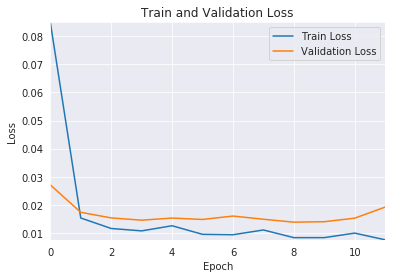

In [3]:
ax = plt.gca()
ax.set_xmargin(0)
ax.set_ymargin(0)
plt.plot(df['epoch'], df['loss'], label="Train Loss")
plt.plot(df['epoch'], df['val_loss'], label="Validation Loss")
plt.legend()
plt.title('Train and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Visualize Final Result

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pyexr
import matplotlib.pyplot as plt
import os

def load_model(model_dir):
    json_file = open(os.path.join('../results/models/', model_dir) + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = keras.models.model_from_json(loaded_model_json)
    loaded_model.load_weights(os.path.join('../results/models/', model_dir) + '.h5')
    
    loaded_model.compile(optimizer=tf.train.AdamOptimizer(0.0001),
              loss='mean_squared_error',
              metrics=['accuracy'])
    
    return loaded_model


In [2]:
original_model_l2 = load_model('deep_shading_batch_normalization_full__epochs_15__lr_9e-05__loss_l2_loss__2018-11-19 15:10:17.860775_model')

original_model_l1 = load_model('deep_shading__lr_9e-05__loss_l1_loss__2018-11-13 21:02:56.132495_model')
        
pyramid_model = load_model('pyramid_res_deep_shading_batch_normalization_full__epochs_15__lr_9e-05__loss_l2_loss__2018-11-16 21:59:48.286878_model')

In [44]:
TESTDATA_DIR = '/media/marcelsantos/DATA/DeepShadingTestImages/'
VALIDATIONDATA_DIR = '/media/marcelsantos/DATA/DeepShadingValidationImages/'
FILE_NAME = '0000000005.exr'
SET = 'TestBears'

# Evaluate loaded model on test data.
normal_image = pyexr.read_all(TESTDATA_DIR + SET + '/Normals/' + FILE_NAME)['default'][:,:,0:3]
position_image = pyexr.read_all(TESTDATA_DIR + SET  + '/Position/'+ FILE_NAME)['default'][:,:,0:3]
input_image = np.dstack([normal_image, position_image])

batch = np.expand_dims(input_image, axis=0)

print('[INFO] Batch Shape', batch.shape)

[INFO] Batch Shape (1, 512, 512, 6)


# Pyramid Model

In [45]:
OUTPUT_NAME =  'pyramid_l2_' + SET + FILE_NAME
data = pyramid_model.predict(batch, 1)[0]

result = np.expand_dims(data[:,:,0], axis=2)
result = np.dstack([result, result, result, np.ones_like(result)])
pyexr.write(os.path.join('../results/images', OUTPUT_NAME), result)

# Original Model L2

In [46]:
OUTPUT_NAME =  'original_model_l2_' + SET + FILE_NAME
data = original_model_l2.predict(batch, 1)[0]

result = np.expand_dims(data[:,:,0], axis=2)
result = np.dstack([result, result, result, np.ones_like(result)])
pyexr.write(os.path.join('../results/images', OUTPUT_NAME), result)

# Orginal Model L1

In [47]:
OUTPUT_NAME =  'original_model_l1_' + SET + FILE_NAME
data = original_model_l1.predict(batch, 1)[0]

result = np.expand_dims(data[:,:,0], axis=2)
result = np.dstack([result, result, result, np.ones_like(result)])
pyexr.write(os.path.join('../results/images', OUTPUT_NAME), result)

# Compare SSIM

In [53]:
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse

In [96]:
TESTDATA_DIR = '/media/marcelsantos/DATA/DeepShadingTestImages/'
VALIDATIONDATA_DIR = '/media/marcelsantos/DATA/DeepShadingValidationImages/'
FILE_NAME = '0000000015.exr'
SET = 'TestCheese'

gt = pyexr.read_all(VALIDATIONDATA_DIR + SET + '/GroundTruth/' + FILE_NAME)['default'][:,:,0:3]
original_model_l1 = pyexr.read_all(os.path.join('../results/images', 'original_model_l1_' + SET + FILE_NAME))['default'][:,:,0:3]
original_model_l2 = pyexr.read_all(os.path.join('../results/images', 'original_model_l2_' + SET + FILE_NAME))['default'][:,:,0:3]
pyramid_model_l2  = pyexr.read_all(os.path.join('../results/images', 'pyramid_l2_' + SET + FILE_NAME))['default'][:,:,0:3]

original_model_l1_ssim = ssim(original_model_l1, gt, multichannel=True)
original_model_l2_ssim = ssim(original_model_l2, gt, multichannel=True)
pyramid_model_l2_ssim = ssim(pyramid_model_l2, gt, multichannel=True)

original_model_l1_mse = mse(original_model_l1, gt)
original_model_l2_mse = mse(original_model_l2, gt)
pyramid_model_l2_mse = mse(pyramid_model_l2, gt)

output =  "original_model_l1_ssim = {}\n"\
          "original_model_l2_ssim = {}\n"\
          "pyramid_model_l2_ssim = {}\n\n"\
          "original_model_l1_mse = {}\n" \
          "original_model_l2_mse = {}\n" \
          "pyramid_model_l2_mse = {}".format(original_model_l1_ssim, original_model_l2_ssim, pyramid_model_l2_ssim,
                                            original_model_l1_mse, original_model_l2_mse, pyramid_model_l2_mse)

In [97]:
print(output)

original_model_l1_ssim = 0.8625339795080564
original_model_l2_ssim = 0.8687917827859252
pyramid_model_l2_ssim = 0.8789409454337361

original_model_l1_mse = 0.012157833924482364
original_model_l2_mse = 0.012538661529287518
pyramid_model_l2_mse = 0.012486986871624237


In [98]:
with open(os.path.join('../results/images',SET+os.path.splitext(FILE_NAME)[0]) + ".txt", "w") as text_file:
    text_file.write(output)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


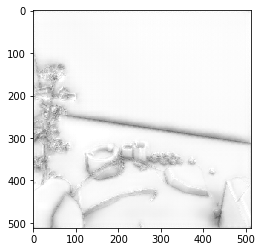